# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [69]:
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

'%.3f'


<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$. While photons (light rays) travel in the expanding universe they get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$


In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\begin{gathered}
\boxed{
H^2 = H_0^2\left[\Omega_\Lambda + \Omega_m (1+z)^3 + \Omega_k (1+z)^2\right]
}
\\
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\end{gathered}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. NB: only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{
  H_0 \equiv 100\,h\,\frac{\rm km}{\rm s\,Mpc}
}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m.

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [82]:
# Hubble rate: from equation (1) and (2)
def Hubble(z, h, Omega_M, Omega_L):

    Omega_O = 1 - Omega_M - Omega_L

    # Calculate H(z) using the provided formula
    H = h * (Omega_L + Omega_M * (1 + z)**3 + Omega_O * (1 + z)**2)**0.5
    return H

# Change these parameters for other results:
h = 0.7
Omega_M = 0.3
Omega_L = 0.7
z = 1  # Redshift

# Compute the Hubble rate at redshift z
Hubble_rate = Hubble(z, Omega_L, Omega_M, h)
print(f"Hubble rate at redshift {z}: {Hubble_rate} km/s/Mpc")


Hubble rate at redshift 1: 1.2324771803161305 km/s/Mpc


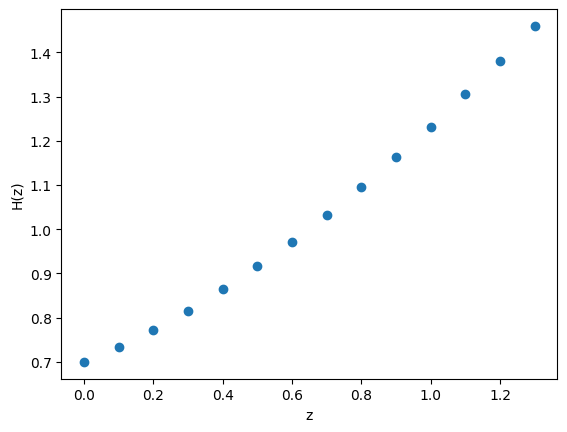

In [71]:
%matplotlib inline
zs = np.arange(0, 1.4, 0.1)
Hs = []
for z in zs:
  Hs += [Hubble(z, Omega_L, Omega_M, h)]

plt.scatter(zs, Hs)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.show()

## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [83]:
from scipy import integrate
import numpy as np

SPEED_OF_LIGHT = 2.998e5  #units: km/s

def D(z, Omega_L, Omega_M, h):
    return h * integrate.quad(lambda x: 1/Hubble(x, Omega_L, Omega_M, h), 0, z)[0]

# Let's just print a sample result
display(D(z, Omega_L, Omega_M, h))

def dL(z, Omega_L, Omega_M, h): # equation (3)
    Dz = D(z, Omega_L, Omega_M, h)
    Omega_K = 1. - Omega_M - Omega_L
    # Calculate different cases based on the value of Omega_k
    if (Omega_K > 0):
        return 10.**4 *SPEED_OF_LIGHT / h * (1 + z) / np.sqrt(Omega_K) * np.sinh(np.sqrt(Omega_K) * Dz)
    elif (Omega_K == 0):
        return 10.**4 * SPEED_OF_LIGHT / h * (1 + z) * Dz
    else:
        return 10.**4 *SPEED_OF_LIGHT / h * (1 + z) / np.sqrt(-Omega_K) * np.sin(-np.sqrt(-Omega_K) * Dz)

def mu(z, Omega_L, Omega_M, h): # equqation (4)
    dL_value = dL(z, Omega_L, Omega_M, h)
    if dL_value <= 0:
        return np.nan  # or any other value that indicates an issue
    else:
        return (5 * np.log10(dL_value / 10))



0.771

<function matplotlib.pyplot.show(close=None, block=None)>

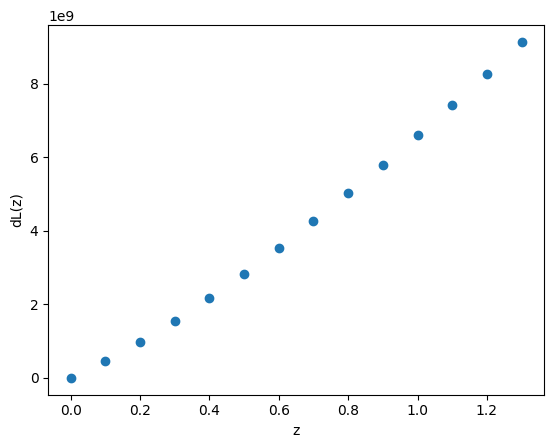

In [73]:
%matplotlib inline

Omega_M = 0.3
Omega_L = 0.7
h = 0.7

zs = np.arange(0, 1.4, 0.1)
dLs = []
for z in zs:
  dLs += [dL(z, Omega_L, Omega_M, h)]

plt.scatter(zs, dLs)
plt.xlabel('z')
plt.ylabel('dL(z)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

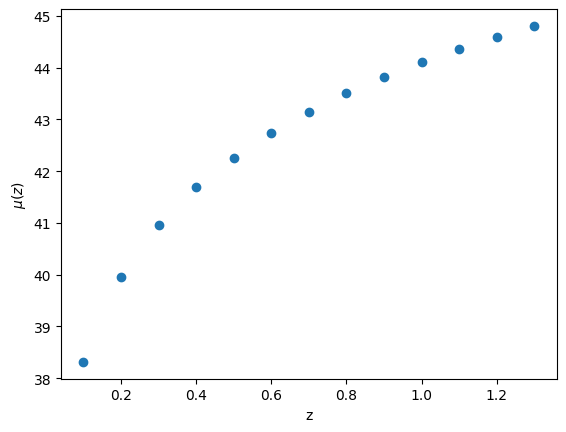

In [74]:
%matplotlib inline

Omega_M = 0.3
Omega_L = 0.7
h = 0.7

zs = np.arange(0.1, 1.4, 0.1)
mus = []
for z in zs :
  mus += [mu(z, Omega_L, Omega_M, h)]

plt.scatter(zs, mus)
plt.xlabel('z')
plt.ylabel('$\mu(z)$')
plt.show

## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [75]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [76]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Data are in columns, so we either slice it by columns: arr[:,n]...
zs = data[:,1] # redshift

# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [84]:
# luminosity distance in pc
luminosity_distance_pc = 10. * 10.**(distance_modulus / 5.)

# and in Mpc
luminosity_distance_Mpc = luminosity_distance_pc / 10.**6

# and the error on that distance:
error_luminosity_distance_Mpc = 5. * (10.**((distance_modulus + error_distance_modulus)/5.-6.) - 10.**((distance_modulus - error_distance_modulus)/5.-6.))

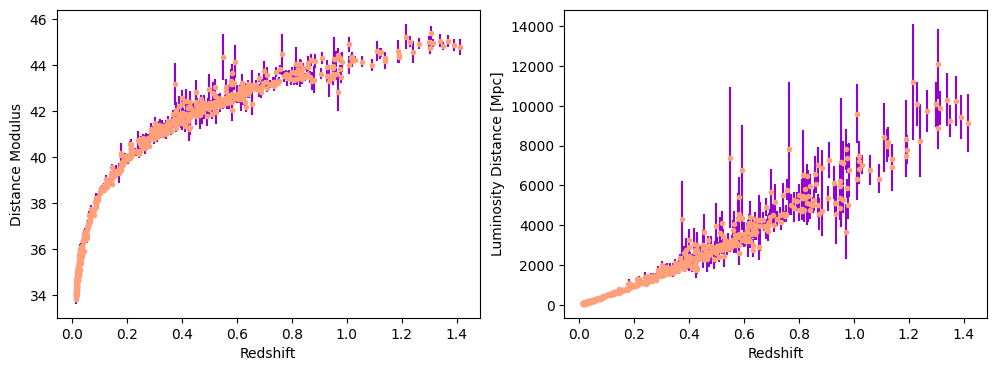

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1, 2, figsize=(12, 4))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='o',\
             color='lightsalmon',\
             ecolor='darkviolet',\
             markersize=3)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, luminosity_distance_Mpc,\
             yerr=error_luminosity_distance_Mpc,\
             fmt='o',\
             color='lightsalmon',\
             ecolor='darkviolet',\
             markersize=3)

plt.show()


## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*).
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$.
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.).

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood.

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not unheard of, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied.
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)


* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Record the step - including **re-recording** if the step was not accepted! </font>
* <font color="deepskyblue"> Repeat</font>

<ipython-input-86-cb3fea6de346>:55: RuntimeWarning: overflow encountered in exp
  probability = np.exp(-delta_chi2 / T)


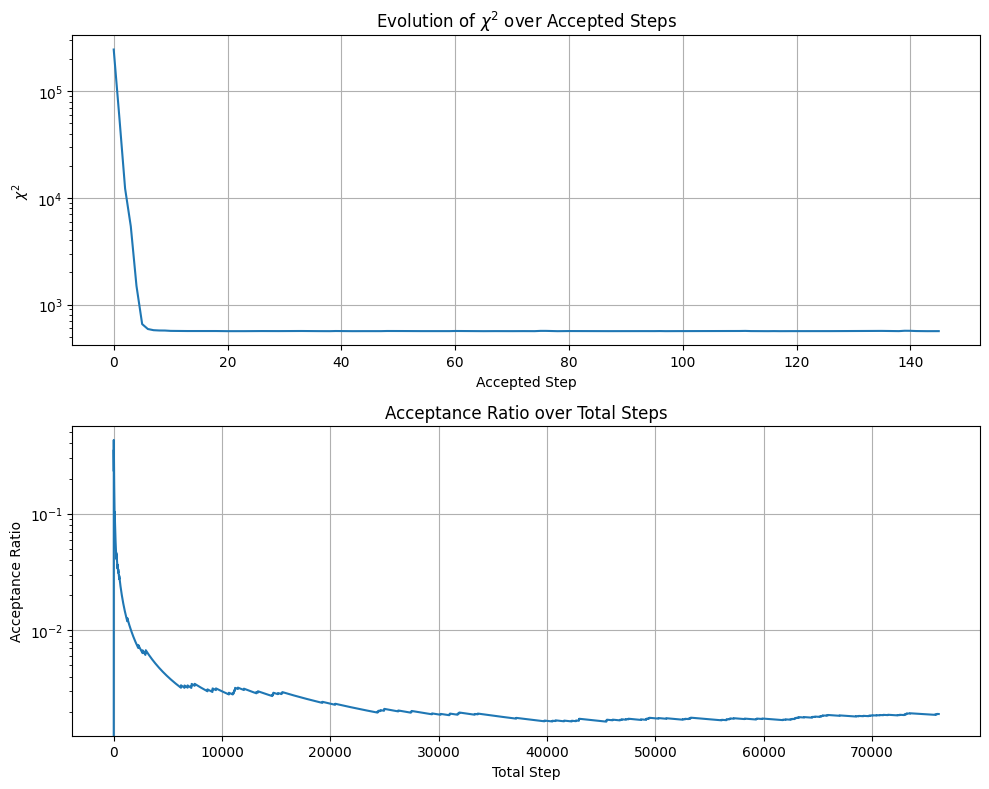

Number of accepted steps: 146
Best values: h = 0.7097079686081489, Omega_M = 0.29326058932738025, Omega_L = 0.6973254514268239


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_mcmc(N_accepted_steps, N_minutes):
    filename = "MC_Chain_SNIa.txt"
    file = open(filename, "w")

    Omega_M_vals = []
    Omega_L_vals = []
    h_vals = []

    # Initial parameter values
    Omega_M = 0.1
    Omega_L = 0.1
    h = 0.1

    # Temperature parameter for Metropolis-Hastings
    T = 0.5

    # Initialize values and counters
    chi2_total_best = 999999999
    chi2_total_list = []
    accepted_steps = 0
    total_steps = 0
    acceptance_ratio_list = []

    # Start time
    start_time = time.time()

    while True:
        if time.time() - start_time > N_minutes * 60 or accepted_steps >= N_accepted_steps:
            break

        Omega_M_new = Omega_M + np.random.normal(0, 0.1)
        Omega_L_new = Omega_L + np.random.normal(0, 0.1)
        h_new = h + np.random.normal(0, 0.1)

        if Omega_M_new < 0.0 or Omega_L_new < 0.0 or h_new < 0.0:
            total_steps += 1
            acceptance_ratio_list.append(accepted_steps / total_steps)  # Update acceptance ratio list
            continue

        chi2_total = 0.
        # Assume the definition of mu and the data variables zs, distance_modulus, error_distance_modulus exist
        for j in range(len(zs)):
            mu_model = mu(zs[j], Omega_L_new, Omega_M_new, h_new)
            chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
            chi2_total += chi2

        total_steps += 1

        if np.isnan(chi2_total):
            acceptance_ratio_list.append(accepted_steps / total_steps)  # Update acceptance ratio list
            continue

        # Calculate delta_chi2 and probability here
        delta_chi2 = chi2_total - chi2_total_best
        probability = np.exp(-delta_chi2 / T)

        if chi2_total < chi2_total_best or np.random.rand() < probability:
            Omega_M = Omega_M_new
            Omega_L = Omega_L_new
            h = h_new
            chi2_total_best = chi2_total
            # Append new values to lists
            Omega_M_vals.append(Omega_M)
            Omega_L_vals.append(Omega_L)
            h_vals.append(h)
            accepted_steps += 1
            chi2_total_list.append(chi2_total_best)

        acceptance_ratio_list.append(accepted_steps / total_steps)  # Update acceptance ratio list

    file.close()

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot chi2 evolution
    axs[0].plot(chi2_total_list)
    axs[0].set_xlabel("Accepted Step")
    axs[0].set_ylabel("$\chi^{2}$")
    axs[0].set_yscale("log")
    axs[0].set_title("Evolution of $\chi^{2}$ over Accepted Steps")
    axs[0].grid(True)

    # Plot acceptance ratio
    axs[1].plot(acceptance_ratio_list)
    axs[1].set_xlabel("Total Step")
    axs[1].set_ylabel("Acceptance Ratio")
    axs[1].set_yscale("log")
    axs[1].set_title("Acceptance Ratio over Total Steps")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print the number of accepted steps and the best parameter values
    print(f"Number of accepted steps: {accepted_steps}")
    print(f"Best values: h = {h}, Omega_M = {Omega_M}, Omega_L = {Omega_L}")
    return h_vals, Omega_M_vals, Omega_L_vals

# Run the MCMC chain:
h, Omega_M, Omega_L = run_mcmc(N_accepted_steps=500, N_minutes=20)


addjustments/improvements i made to the original assignments:

1. I have modified the loop to terminate based on two alternative conditions. The first condition allows the loop to stop once a specified number of minutes has elapsed. This duration can be adjusted as needed. The second condition involves the completion of a certain number of accepted steps. This quantity, too, can be customized to suit the requirements.
2. I added acception ratio that can is shown in the graph above


## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$? To a high degree of significance?

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>

Length of h: 146
Length of Omega_M: 146
Length of Omega_L: 146
Length of Omega_k: 146
Removed no burn in
0.57 < h < 0.71 at 68% CL
0.14 < Omega_M < 0.28 at 68% CL
0.70 < Omega_L < 0.70 at 68% CL
0.02 < Omega_k < 0.16 at 68% CL


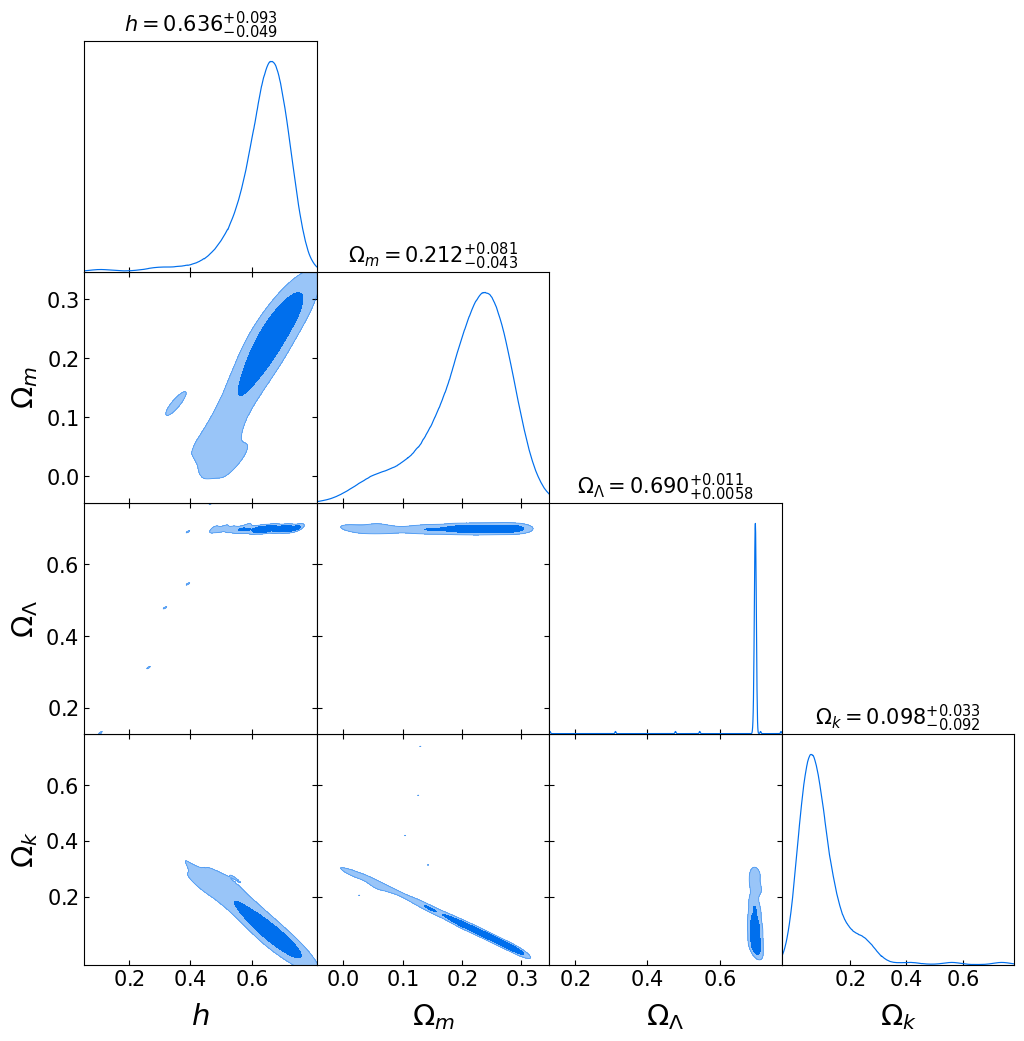

In [88]:
import getdist
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt

# Assuming h, Omega_M, and Omega_L are your MCMC results
# Example: h, Omega_M, Omega_L = run_your_mcmc_simulation()

# Dynamically determine the number of steps
N_steps = len(h)

# Ensure Omega_M and Omega_L are numpy arrays for vectorized operations
Omega_M = np.array(Omega_M)
Omega_L = np.array(Omega_L)

# Calculate Omega_k
Omega_k = 1. - Omega_M - Omega_L

# Define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h','Omega_M', 'Omega_L', 'Omega_k']
my_dim = len(my_names)  # The number of variables we're plotting

print(f"Length of h: {len(h)}")
print(f"Length of Omega_M: {len(Omega_M)}")
print(f"Length of Omega_L: {len(Omega_L)}")
print(f"Length of Omega_k: {len(Omega_k)}")

if len(h) == len(Omega_M) == len(Omega_L) == len(Omega_k):
    # Create a 2D array with each parameter as a column
    data = np.array([h, Omega_M, Omega_L, Omega_k]).T

    # Create an "MCSamples" data type for GetDist
    my_samples = MCSamples(samples=data, names=my_names, labels=my_labels)

    # Confidence level, e.g., 1-sigma (68.27%)
    conf_level = 0.6827

    # Printing the 1D posteriors with confidence levels
    for nam in my_names:
        lower = my_samples.confidence(nam, (1.-conf_level)/2., upper=False)
        upper = my_samples.confidence(nam, (1.-conf_level)/2., upper=True)
        print(f"{lower:.2f} < {nam} < {upper:.2f} at {int(100*conf_level)}% CL")

    # Triangle corner plot
    plotter = plots.getSubplotPlotter(subplot_size=3)
    plotter.settings.axes_labelsize = 22
    plotter.settings.axes_fontsize = 16
    plotter.triangle_plot(my_samples, filled=True, title_limit=1)
else:
    print("Error: The arrays have inconsistent lengths.")

The shapeds of the graph where not realy what i would expect. but the The errors are very low wich could explain this

## <font color='deepskyblue'>Further Improvements</font>

There are many ways in which you can improve your code and/or your data visualisation. Some ideas, in random order:

* Modify your priors and compare your results. For instance:
  * Change to log-flat priors for $h$ and/or $\Omega_m$, namely displace them in log-space instead of linear space:
  $$
  \log(h_{\rm new}) = \log(h_{\rm old}) + \delta
  $$
  where $\delta$ a random variable of mean 0
  * Use priors from other cosmological probes, for example the [Planck 2018 results](https://arxiv.org/abs/1807.06209):
  $$
  \Omega_m = 0.315 \pm 0.007\,,~\dots
  $$
* Monitor acceptance ratio and $\chi^2$ as a function of step count
* Implement a Gelman-Rubin (or alternative) convergence test
* Change colours and other properties of your triangle plot
* Re-plot the data with your theoretical fits: you can try both your best fit, and some $1\sigma$ "error bars"
* Split your data in redshift bins and repeat the analysis for each bin individually.
<br> _(What do you notice? Which redshift bins give us the most accurate detection of the cosmological parameters?)_